# Load dependencies:

In [21]:
import re
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
transformation = lambda s: " ".join([lemmatizer.lemmatize(word) for word in re.sub('[\W\d]+', ' ', s).lower().split() if word not in stop_words])

[nltk_data] Downloading package wordnet to /fp/homes01/u01/ec-
[nltk_data]     sushantg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /fp/homes01/u01/ec-
[nltk_data]     sushantg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation

In [22]:
# read /fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz
dataset = pd.read_csv("/fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz", compression="gzip")
dataset['abstract_org'] = dataset['abstract'] #backup
# dataset['abstract'] = dataset['abstract'].str.replace('\n', ' ')
# dataset['abstract'] = dataset['abstract'].str.replace('\t', ' ')
# dataset['abstract'] = dataset['abstract'].str.replace('_', ' ')
# dataset['abstract'] = dataset['abstract'].str.replace('-', ' ')
# dataset['abstract'] = dataset['abstract'].str.replace('\d+', ' ')
# dataset['abstract'] = dataset['abstract'].apply(lambda x: x.lower().split(" "))
# dataset['abstract'] = dataset['abstract'].apply(lambda x: [w for w in x if not w in stop_words])
# dataset['abstract'] = dataset['abstract'].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x]))
dataset['abstract'] = dataset['abstract'].apply(transformation)
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset = dataset.reset_index(drop=True)
dataset['id']= dataset.index

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset['id'], dataset['label'], test_size=0.3, random_state=42, stratify=dataset['label'])
id2label = dict(enumerate(dataset['label'].unique()))
label2id = {v: k for k, v in id2label.items()}

In [25]:
corpus = dataset['abstract']

count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(corpus)
# count_vectorizer.get_feature_names_out()

binary_vectorizer = CountVectorizer(binary=True)
X_binary = binary_vectorizer.fit_transform(corpus)

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

print("X- shpe", X_tfidf.shape)

X- shpe (80000, 85729)


# Helper functions

In [26]:
class CustomDataset(Dataset):
    def __init__(self, indices, X_vec, labels):
        self.indices = list(indices)
        self.X_vec = X_vec
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        index = self.indices[idx]
        # Convert sparse matrix slice to dense
        x = self.X_vec[index].toarray()
        y_str = self.labels[index]
        y= label2id[y_str]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

num_classes = len(id2label)

In [83]:
class TextClassifier(nn.Module):
    def __init__(self, input_size, layer_map=[128], dropout_rate=0.6):
        super(TextClassifier, self).__init__()
        self.fc_layers = nn.ModuleList()  # ModuleList to hold dynamically created layers
        self.dropout = nn.Dropout(dropout_rate)
        prev_layer_size = input_size
        for size in layer_map:
            self.fc_layers.append(nn.Linear(prev_layer_size, size))
            prev_layer_size = size
        self.fc_out = nn.Linear(prev_layer_size, num_classes)

    def forward(self, x):
        for layer in self.fc_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.squeeze(1).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values()), zero_division=0))


def plot_loss_curve(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [85]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    model.to(device)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.squeeze(1).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.squeeze(1).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        val_loss.append(running_loss / len(val_loader))
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.6f}, Val. Loss: {val_loss[-1]:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}')

    return train_loss, val_loss

In [86]:
lr=0.0005
batch_size=10000
epochs=50
criterion = nn.CrossEntropyLoss()

In [87]:
def train_evaluate(X_vector, model_layer_map=[128], lr_=lr, epochs_=epochs, batch_size_=batch_size ): # custom model can also be passes
    print("Initializing model with lr = {}, batch_size = {}, epochs = {}".format(lr_, batch_size_, epochs_))
    model=TextClassifier(layer_map=model_layer_map, input_size=X_vector.shape[1])
    optimizer= torch.optim.Adam(model.parameters(), lr=lr_)
    train_loader = DataLoader(CustomDataset(X_train, X_vector, y_train), batch_size=batch_size_, shuffle=True)
    test_loader = DataLoader(CustomDataset(X_test, X_vector, y_test), batch_size=batch_size_, shuffle=False)
    train_loss, val_loss = train(model, criterion, optimizer, train_loader, test_loader, epochs=epochs_)
    evaluate(model, test_loader)
    return model, train_loss, val_loss

# Experiments

## BOW Variations

Experiment A-1: Using Binary vectorizer
Initializing model with lr = 0.0005, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.228308, Val. Loss: 2.104806, Precision: 0.791612, Recall: 0.742994, F1: 0.744885
Epoch 2, Train Loss: 1.999433, Val. Loss: 1.878863, Precision: 0.804596, Recall: 0.791963, F1: 0.793689
Epoch 3, Train Loss: 1.758696, Val. Loss: 1.651375, Precision: 0.806431, Recall: 0.800230, F1: 0.800398
Epoch 4, Train Loss: 1.521722, Val. Loss: 1.435545, Precision: 0.808532, Recall: 0.804372, F1: 0.803526
Epoch 5, Train Loss: 1.303746, Val. Loss: 1.243688, Precision: 0.810731, Recall: 0.808460, F1: 0.807307
Epoch 6, Train Loss: 1.114776, Val. Loss: 1.082564, Precision: 0.814236, Recall: 0.813039, F1: 0.812022
Epoch 12, Train Loss: 0.544519, Val. Loss: 0.636931, Precision: 0.830006, Recall: 0.830369, F1: 0.829812
Epoch 13, Train Loss: 0.502606, Val. Loss: 0.609063, Precision: 0.832200, Recall: 0.832357, F1: 0.831893
Epoch 14, Train Loss: 0.466344, Val. Loss: 0.586658, Prec

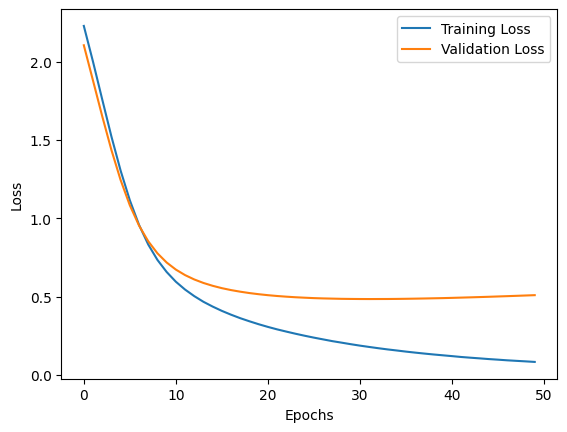

In [16]:
print("Experiment A-1: Using Binary vectorizer")
model_b, train_loss_b, val_loss_b = train_evaluate(X_binary, lr_=lr)
plot_loss_curve(train_loss_b, val_loss_b)

Experiment A-2: Using Count vectorizer
Initializing model with lr = 0.0005, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.188012, Val. Loss: 2.001308, Precision: 0.785690, Recall: 0.681790, F1: 0.689769
Epoch 2, Train Loss: 1.851123, Val. Loss: 1.685788, Precision: 0.796782, Recall: 0.769563, F1: 0.771762
Epoch 3, Train Loss: 1.532615, Val. Loss: 1.406520, Precision: 0.808221, Recall: 0.800499, F1: 0.800509
Epoch 4, Train Loss: 1.260182, Val. Loss: 1.177561, Precision: 0.815057, Recall: 0.811614, F1: 0.811643
Epoch 5, Train Loss: 1.041412, Val. Loss: 1.000839, Precision: 0.820586, Recall: 0.819187, F1: 0.819094
Epoch 6, Train Loss: 0.873784, Val. Loss: 0.871223, Precision: 0.822784, Recall: 0.822066, F1: 0.821857
Epoch 7, Train Loss: 0.750404, Val. Loss: 0.778209, Precision: 0.825827, Recall: 0.825402, F1: 0.825070
Epoch 8, Train Loss: 0.658679, Val. Loss: 0.711457, Precision: 0.828681, Recall: 0.828322, F1: 0.828107
Epoch 9, Train Loss: 0.589363, Val. Loss: 0.662991, Precisio

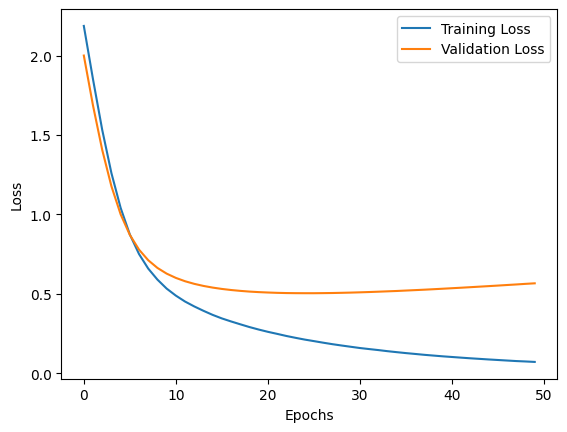

In [31]:
print("Experiment A-2: Using Count vectorizer")
model_c, train_loss_c, val_loss_c = train_evaluate(X_count, lr_=lr)
plot_loss_curve(train_loss_c, val_loss_c)

Experiment A-3: Using TF-IDF vectorizer
Initializing model with lr = 0.001, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.287045, Val. Loss: 2.258178, Precision: 0.583294, Recall: 0.257671, F1: 0.204572
Epoch 2, Train Loss: 2.228973, Val. Loss: 2.195324, Precision: 0.774238, Recall: 0.659419, F1: 0.642050
Epoch 3, Train Loss: 2.154566, Val. Loss: 2.117345, Precision: 0.776230, Recall: 0.749451, F1: 0.730996
Epoch 4, Train Loss: 2.063055, Val. Loss: 2.023084, Precision: 0.788222, Recall: 0.774081, F1: 0.760466
Epoch 5, Train Loss: 1.953939, Val. Loss: 1.912207, Precision: 0.795180, Recall: 0.785169, F1: 0.774636
Epoch 6, Train Loss: 1.828313, Val. Loss: 1.786069, Precision: 0.799549, Recall: 0.791833, F1: 0.783355
Epoch 11, Train Loss: 1.086052, Val. Loss: 1.099920, Precision: 0.817550, Recall: 0.816300, F1: 0.813898
Epoch 12, Train Loss: 0.959491, Val. Loss: 0.992161, Precision: 0.819527, Recall: 0.818833, F1: 0.817184
Epoch 13, Train Loss: 0.851166, Val. Loss: 0.901451, Preci

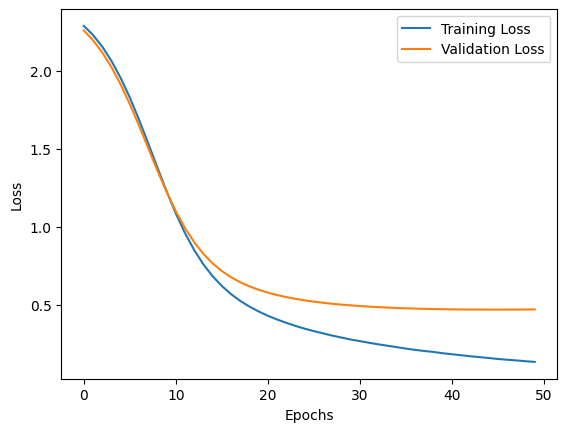

In [32]:
print("Experiment A-3: Using TF-IDF vectorizer")
model_t, train_loss_t, val_loss_t = train_evaluate(X_tfidf, lr_=0.001) #lower rate for IFIDF
plot_loss_curve(train_loss_t, val_loss_t)

## Layer Variations with best vectorizer (TF-IDF )
Note: Size of a single hidden layer used above for experiment A-3 was [128].

In [103]:
lr= 0.0005
batch_size=10000
epochs=50

Experiment B-1: Using hidden layers of size [256]
Initializing model with lr = 0.001, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.277975, Val. Loss: 2.233919, Precision: 0.771459, Recall: 0.697018, F1: 0.665290
Epoch 2, Train Loss: 2.188163, Val. Loss: 2.133007, Precision: 0.807976, Recall: 0.794549, F1: 0.786569
Epoch 3, Train Loss: 2.066920, Val. Loss: 2.003169, Precision: 0.813860, Recall: 0.804747, F1: 0.799890
Epoch 4, Train Loss: 1.914369, Val. Loss: 1.844484, Precision: 0.815435, Recall: 0.808030, F1: 0.804421
Epoch 5, Train Loss: 1.732464, Val. Loss: 1.661511, Precision: 0.816412, Recall: 0.809858, F1: 0.806903
Epoch 6, Train Loss: 1.529001, Val. Loss: 1.464854, Precision: 0.817285, Recall: 0.812451, F1: 0.809916
Epoch 7, Train Loss: 1.317389, Val. Loss: 1.270207, Precision: 0.818644, Recall: 0.815378, F1: 0.813122
Epoch 11, Train Loss: 0.680329, Val. Loss: 0.742915, Precision: 0.825562, Recall: 0.825349, F1: 0.824702
Epoch 12, Train Loss: 0.593406, Val. Loss: 0.6786

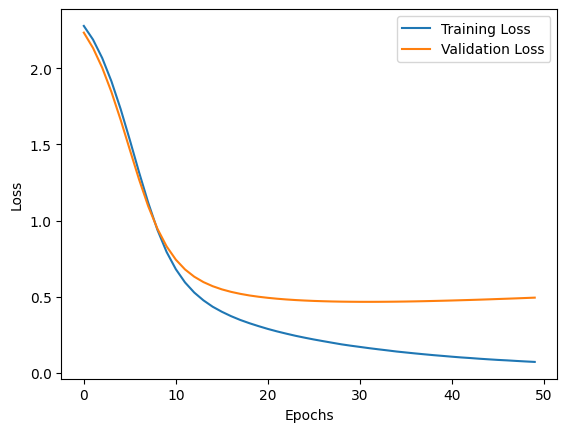

In [51]:
layer_map_ =[256]
print("Experiment B-1: Using hidden layers of size", layer_map_ )
model_l1, train_loss_l1, val_loss_l1 = train_evaluate(X_tfidf, model_layer_map= layer_map_, lr_=lr, epochs_=epochs, batch_size_=batch_size)
plot_loss_curve(train_loss_l1, val_loss_l1)

Experiment B-2: Using hidden layers of size [4096]
Initializing model with lr = 0.0005, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.257128, Val. Loss: 2.167163, Precision: 0.811663, Recall: 0.803039, F1: 0.801582
Epoch 2, Train Loss: 2.069666, Val. Loss: 1.933005, Precision: 0.812598, Recall: 0.804371, F1: 0.801140
Epoch 3, Train Loss: 1.788218, Val. Loss: 1.620040, Precision: 0.812281, Recall: 0.805327, F1: 0.801597
Epoch 4, Train Loss: 1.441571, Val. Loss: 1.279378, Precision: 0.813864, Recall: 0.808911, F1: 0.805374
Epoch 5, Train Loss: 1.098513, Val. Loss: 0.985289, Precision: 0.817286, Recall: 0.816028, F1: 0.813784
Epoch 6, Train Loss: 0.827069, Val. Loss: 0.779805, Precision: 0.820953, Recall: 0.820815, F1: 0.819912
Epoch 7, Train Loss: 0.644880, Val. Loss: 0.655007, Precision: 0.824747, Recall: 0.824520, F1: 0.824050
Epoch 8, Train Loss: 0.530498, Val. Loss: 0.581802, Precision: 0.829274, Recall: 0.829144, F1: 0.828751
Epoch 9, Train Loss: 0.456118, Val. Loss: 0.5375

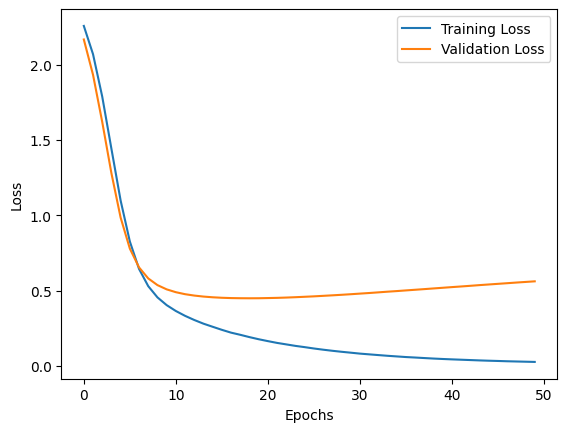

In [91]:
layer_map_ =[4096]
print("Experiment B-2: Using hidden layers of size", layer_map_ )
model_l2, train_loss_l2, val_loss_l2 = train_evaluate(X_tfidf, model_layer_map= layer_map_, lr_=lr, epochs_=epochs, batch_size_=batch_size)
plot_loss_curve(train_loss_l2, val_loss_l2)

Experiment B-3: Using hidden layers of size [4096, 128]
Initializing model with lr = 0.0005, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.287330, Val. Loss: 2.248853, Precision: 0.715222, Recall: 0.434162, F1: 0.352483
Epoch 2, Train Loss: 2.189250, Val. Loss: 2.077287, Precision: 0.716846, Recall: 0.667083, F1: 0.646101
Epoch 3, Train Loss: 1.951844, Val. Loss: 1.749488, Precision: 0.722354, Recall: 0.694504, F1: 0.664403
Epoch 4, Train Loss: 1.592443, Val. Loss: 1.333481, Precision: 0.764230, Recall: 0.741407, F1: 0.717280
Epoch 5, Train Loss: 1.221111, Val. Loss: 0.969997, Precision: 0.794134, Recall: 0.792885, F1: 0.785800
Epoch 6, Train Loss: 0.932080, Val. Loss: 0.741858, Precision: 0.806634, Recall: 0.808129, F1: 0.804967
Epoch 7, Train Loss: 0.744173, Val. Loss: 0.622518, Precision: 0.817410, Recall: 0.818448, F1: 0.816427
Epoch 8, Train Loss: 0.623934, Val. Loss: 0.557970, Precision: 0.824517, Recall: 0.825504, F1: 0.824580
Epoch 9, Train Loss: 0.539020, Val. Loss: 0

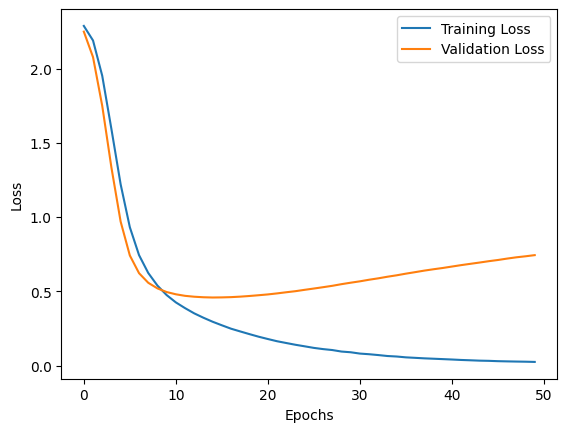

In [92]:
layer_map_ =[4096, 128]
print("Experiment B-3: Using hidden layers of size", layer_map_ )
model_l3, train_loss_l3, val_loss_l3 = train_evaluate(X_tfidf, model_layer_map= layer_map_, lr_=lr, epochs_=epochs, batch_size_=batch_size)
plot_loss_curve(train_loss_l3, val_loss_l3)

Experiment B-4: Using hidden layers of size [512, 128, 16]
Initializing model with lr = 0.0005, batch_size = 10000, epochs = 50
Epoch 1, Train Loss: 2.310312, Val. Loss: 2.306935, Precision: 0.010033, Recall: 0.100000, F1: 0.018237
Epoch 2, Train Loss: 2.303196, Val. Loss: 2.296764, Precision: 0.020134, Recall: 0.108977, F1: 0.029400
Epoch 3, Train Loss: 2.292304, Val. Loss: 2.280257, Precision: 0.121245, Recall: 0.184465, F1: 0.116286
Epoch 4, Train Loss: 2.273461, Val. Loss: 2.252806, Precision: 0.071618, Recall: 0.209353, F1: 0.088671
Epoch 5, Train Loss: 2.243853, Val. Loss: 2.208104, Precision: 0.112601, Recall: 0.187450, F1: 0.067564
Epoch 6, Train Loss: 2.198638, Val. Loss: 2.139816, Precision: 0.308597, Recall: 0.184539, F1: 0.071606
Epoch 7, Train Loss: 2.136011, Val. Loss: 2.047434, Precision: 0.572614, Recall: 0.240110, F1: 0.167646
Epoch 8, Train Loss: 2.064887, Val. Loss: 1.940854, Precision: 0.634777, Recall: 0.440264, F1: 0.412535
Epoch 9, Train Loss: 1.983758, Val. Loss

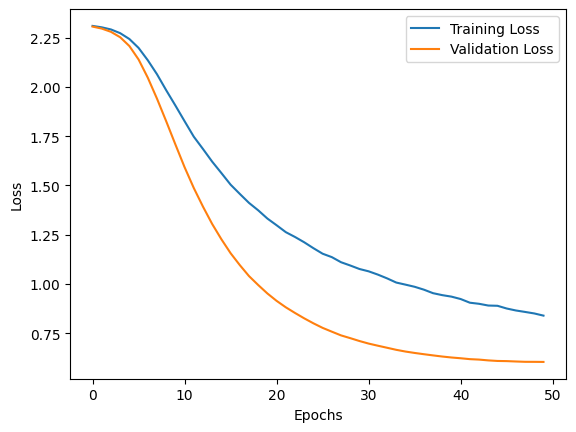

In [105]:
layer_map_ =[512, 128, 16]
print("Experiment B-4: Using hidden layers of size", layer_map_ )
model_l4, train_loss_l4, val_loss_l4 = train_evaluate(X_tfidf, model_layer_map= layer_map_, lr_=lr, epochs_=epochs, batch_size_=batch_size)
plot_loss_curve(train_loss_l4, val_loss_l4)

# Inference using best model using its vectorizer

In [101]:
best_model = model_t
best_tokenizer = tfidf_vectorizer

input_text = "They believed sun and moon revolved around the earth circle parameter square, what a dsdddsdhbsdjnsd"
vector_text = tfidf_vectorizer.transform([input_text]).toarray()
probabilities = best_model(torch.tensor(vector_text, dtype=torch.float32).to(device))[0]

sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
_ = [print(f"Label: {id2label[index.item()]}, Probability: {prob.item()}") for index, prob in zip(sorted_indices, sorted_probs)]

Label: astro-ph, Probability: 1.2469582557678223
Label: physics, Probability: 1.227086067199707
Label: math, Probability: 0.38458487391471863
Label: hep-ph, Probability: 0.35797828435897827
Label: hep-th, Probability: -0.46099528670310974
Label: cond-mat, Probability: -0.5525451302528381
Label: eess, Probability: -0.6740991473197937
Label: cs, Probability: -0.7948992848396301
Label: quant-ph, Probability: -1.14994215965271
Label: stat, Probability: -1.5684995651245117
